In [13]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import recommendations
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [14]:
df = pd.read_csv('../datasets/processed_dataset.csv')
df = df[['Student Number', 'Course Code', 'Letter Grade', 'Semester', 'Course Credit', 'GPA', 'Completed Credits', 'Department Code']]
df

,Student Number,Course Code,Letter Grade,Semester,Course Credit,GPA,Completed Credits,Department Code
0,1182,MGT 511,A-,2011 - Fall,3,3.54,15,MBA/NT
1,134,UNI 123,C-,2011 - Fall,3,3.67,18,EE
2,217,UNI 115,A-,2011 - Fall,3,3.70,3,CTV
3,1227,MGT 511,B,2011 - Fall,3,3.00,15,MBA/NT
4,1225,MGT 541,B+,2011 - Fall,3,3.33,9,MBA/NT
...,...,...,...,...,...,...,...,...
49342,1311,EECS 216,F,2014 - Spring,3,2.91,69,EE
49343,1311,EECS 202,D+,2014 - Spring,3,2.91,69,EE
49344,1311,EECS 218,B-,2014 - Spring,3,2.91,69,EE
49345,173,CTV 212,C+,2014 - Spring,3,1.97,57,CTV


In [15]:
df = pd.concat([df, pd.get_dummies(df['Department Code'], prefix='Department Code')], axis=1)
df.drop(['Department Code'], axis=1, inplace=True)

In [16]:
numerical_grades = {'A+': 4.1, 'A': 4.0, 'A-': 3.7, 'B+': 3.3, 'B': 3.0, 'B-': 2.7, 'C+': 2.3, 'C': 2.0,
                    'C-': 1.7, 'D+': 1.3, 'D': 1.0, 'D-': 0.5, 'F': 0.0}

In [17]:
course_credits = {}
for row_idx in df.index:
    course_code = df.iloc[row_idx, 1]
    credit = df.iloc[row_idx, 4]    
    course_credits[course_code] = credit

In [18]:
def get_semester_data(semester_name):
    semester_data = {}   # semester data in shape {student_number: {course_code: letter_grade, ...}, ...}
    
    # extracting the instances with the given semester_name from the main dataFrame
    dataset = df[df.iloc[:, 3] == semester_name]
    dataset.index = range(len(dataset))
    
    # filling the semester_data dictionary
    for row_idx in dataset.index:
        student_number = dataset.iloc[row_idx, 0]
        course_code = dataset.iloc[row_idx, 1]
        letter_grade = dataset.iloc[row_idx, 2]
        
        semester_data.setdefault(student_number, {})
        semester_data[student_number][course_code] = numerical_grades[letter_grade]
    
    return semester_data

In [19]:
def get_avg_gpa(train_semester, student):
    courses = train_semester[student]
    total_credit = 0
    weights = 0
    for course in courses:
        total_credit += course_credits[course]
        weights += courses[course] * course_credits[course]
    
    return weights / total_credit

In [20]:
def fit_cluster(train_sems, num_clusters, training_data, cluster_model):
    train_dataset = pd.DataFrame(columns=df.columns)
    
    # extracting instances from the dataset which should be in training data
    for sem in train_sems:
        train_dataset = pd.concat([train_dataset, df[df.iloc[:, 3] == sem]], ignore_index=True)

    cluster_features = train_dataset[['GPA', 'Completed Credits'] + list(train_dataset.columns[7:])]
    
    # fitting a clustering model based on GPA, Completed Credits and Departments
    fitted_cluster_model = cluster_model(n_clusters=num_clusters).fit(cluster_features)
    cluster_labels = fitted_cluster_model.labels_
    
    cluster_dataset = {}   # splitting the train dataset into sub-dicts based on their predicted cluster label
    
    # assigning each students' data to their predicted clusters
    for i in range(len(cluster_labels)):
        cluster_dataset.setdefault(cluster_labels[i], {})
        student_number = train_dataset.iloc[i, 0]
        cluster_dataset[cluster_labels[i]][student_number] = training_data[student_number]
    
    return cluster_dataset, fitted_cluster_model

In [21]:
def cluster_test_data(cluster_model, semester_name):
    # extracting all instances with the given semester_name from the main dataFrame
    test_dataset = df[df.iloc[:, 3] == semester_name]
    test_dataset.index = range(len(test_dataset))
    
    # predicting the cluster labels of test data using a cluster model fitted on the train data so far
    cluster_features = test_dataset[['GPA', 'Completed Credits'] + list(test_dataset.columns[7:])]
    cluster_labels = cluster_model.predict(cluster_features)
    
    # getting the semester data of available students in test semester
    semester_data = get_semester_data(semester_name)
    
    cluster_dataset = {}   # splitting the test dataset into sub-dicts based on their predicted cluster label
    
    # assigning each students' data to their predicted clusters
    for i in range(len(cluster_labels)):
        cluster_dataset.setdefault(cluster_labels[i], {})
        student_number = test_dataset.iloc[i, 0]
        cluster_dataset[cluster_labels[i]][student_number] = semester_data[student_number]
    return cluster_dataset    

In [22]:
def get_errors(train_semester, test_semester, sim):
    average_gpa = {}
    y_true = []
    y_pred = []
    
    # predicting recommended courses for each student in training data
    for student in train_semester:
        recommended_courses = {}
        recs = recommendations.getRecommendations(train_semester, student, sim)
        
        for rec_grade, rec_course in recs:
            recommended_courses.setdefault(rec_course, rec_grade)
            
        average_gpa.setdefault(student, get_avg_gpa(train_semester, student))
        
        # skipping students from training data who do not have not taken courses in test data
        if student not in test_semester:
            continue
            
        # checking for students' test data records in recommended courses
        for course_code in test_semester[student]:
            y_true.append(test_semester[student][course_code])
            if course_code in recommended_courses:   # considering the predicted grade if course is availabel
                y_pred.append(recommended_courses[course_code])
            else:   # considering the average GPA if course is not available in recommended courses
                y_pred.append(average_gpa[student])
        
    # calculating the error metrics
    if len(y_true) == 0:
        rmse = None
        mae = None
    else:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
    
    return rmse, mae

In [23]:
def predict(sim, cluster_model):
    error_scores = {} # storing error scores in a dict with shape: 
                      # {num_clusters (k=2,3,...,7): 
                        # {num_training_semesters (N=1,2,...,7): 
                            # {cluster_label: [RMSE, MAE], ...}, 
                        # ...}, 
                      #...}
    
    sorted_semesters = sorted(set(df.iloc[:, 3]))   # sorting semesters in a time series manner
    for num_clusters in range(2, 8):
        error_scores.setdefault(str(num_clusters), {})
        train_semester = {}   # {student_number: {course_code: letter_grade, ...}, ...}
        for sem_idx in range(1, len(sorted_semesters)):
            error_scores[str(num_clusters)].setdefault(str(sem_idx), {})
            
            # combining all previous semesters in dataset and consider it as training semester
            new_semester = get_semester_data(sorted_semesters[sem_idx-1])
            for student in new_semester:
                if student in train_semester:   # combine data if a student already exist
                    train_semester[student].update(new_semester[student])
                else:   # create a new key-value pair for students with no record
                    train_semester[student] = new_semester[student]
            
            training_semesters_name = sorted_semesters[:sem_idx]   # names of all training semesters
            
            # getting the cluster model fitted on training data and each clusters' training data
            train_cluster_data, fitted_cluster_model = fit_cluster(training_semesters_name, num_clusters, train_semester, cluster_model)
            
            # getting the clustered test data
            test_semester_name = sorted_semesters[sem_idx]
            test_cluster_data = cluster_test_data(fitted_cluster_model, test_semester_name)
            
            # fitting each cluster label with a similarity metric, and measure the error between the same
            # cluster labels in training and test data
            for cluster_label in train_cluster_data:
                rmse, mae = get_errors(train_cluster_data[cluster_label], test_cluster_data[cluster_label], sim)
                error_scores[str(num_clusters)][str(sem_idx)][str(cluster_label)] = [rmse, mae]
        
    return error_scores

In [28]:
def plot_errors(errors, sim):
    x = np.arange(7)
    fig, ax = plt.subplots(figsize=(11, 5.5))
    rects1 = ax.bar(x - 0.35/2, errors['RMSE'], 0.35, label='RMSE')
    rects2 = ax.bar(x + 0.35/2, errors['MAE'], 0.35, label='MAE')
    for i, v in enumerate(errors['RMSE']):
        ax.text(i-0.36, v + 0.01, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold')
    for i, v in enumerate(errors['MAE']):
        ax.text(i-0.01, v + 0.01, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold')
    ax.set_ylabel('Error', fontsize=22, fontfamily='serif')
    ax.set_title('Error Metrics with N training semesters ({})'.format(sim), fontsize=22, fontfamily='serif')
    ax.set_xticks(x)
    ax.set_xticklabels(['N={}'.format(i+1) for i in range(7)], fontsize=22, fontfamily='serif')
    ax.set_yticklabels([round(i,1) for i in ax.get_yticks()], fontsize=22, fontfamily='serif')
    ax.tick_params(labelsize=22)
    ax.grid(True)
    ax.legend(prop={'size': 18, 'family': 'serif'}, loc='center', bbox_to_anchor=(0.5, -0.15), ncol=2)

In [ ]:
model_errors = {}

In [25]:
with open('../results/clustering_based_collaborative_filtering_results (Student based with KMeans).json') as fr:
    results = json.load(fr)

In [ ]:
errors = predict(recommendations.sim_distance, KMeans)
model_errors['Euclidean Distance'] = errors

In [30]:
results['Euclidean Distance']

{'7': {'7': {'0': [1.2975945158137114, 0.8398891352549889],
   '2': [1.0981619954112158, 0.8382592891971671],
   '5': [1.0457378420287864, 0.8188378352504935],
   '6': [1.8562366043772414, 1.6473233908948195],
   '4': [1.284550932986358, 0.9668008048289738],
   '1': [1.4145846110994216, 1.1343306864656193],
   '3': [1.173755092386367, 0.9269386310145971]},
  '2': {'0': [1.548889118045575, 1.2075],
   '2': [0.977073639926231, 0.7208799152437122],
   '5': [1.1961341206113723, 0.937048611111111],
   '6': [None, None],
   '4': [0.7513160866565852, 0.5620689655172413],
   '1': [1.3006049261141215, 1.0016578322742706],
   '3': [1.4813060706875532, 1.1925839551894537]},
  '5': {'0': [1.389207278119976, 0.9445592705167171],
   '2': [1.0600978436052633, 0.837909090909091],
   '5': [1.7789713007490844, 1.6494444444444445],
   '6': [1.09773629409827, 0.8540017700595568],
   '4': [1.4006038710869335, 0.8930555555555554],
   '1': [1.560057302754866, 1.2566666666666666],
   '3': [1.1566682662486314,

KeyError: 'RMSE'

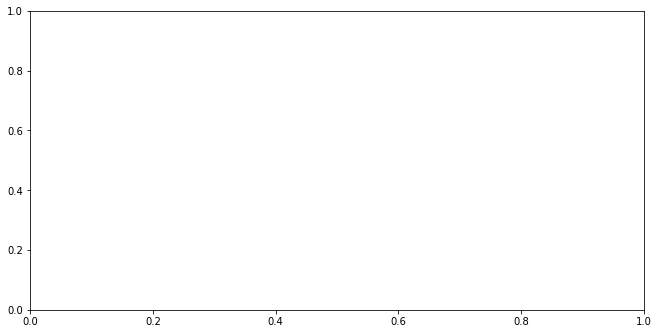

In [29]:
plot_errors(results['Euclidean Distance'], 'Euclidean Distance')

In [ ]:
errors = predict(recommendations.sim_jaccard, KMeans)
model_errors['Jaccard Index'] = errors

In [ ]:
errors = predict(recommendations.sim_pearson, KMeans)
model_errors['Pearson Correlation'] = errors

In [ ]:
with open('clustering_based_collaborative_filtering_results (with KMeans).json', 'w') as fw:
    json.dump(model_errors, fw)